In [1]:
#importing packages
import pandas as pd
import numpy as np

In [2]:
# Importing the dataset
X = pd.read_csv('../Datasets/NB.csv')
X['Fault'] = 0

y = pd.read_csv('../Datasets/OR - 7.csv')
y['Fault'] = 1

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 0)

y_train, y_test = train_test_split(y, test_size = 0.2, random_state = 0)

In [4]:
train = X_train.append(y_train)
train

,DE,FE,Fault
103476,0.062585,0.041091,0
96984,-0.075102,-0.013765,0
114732,-0.048190,-0.001233,0
10916,0.069260,0.028558,0
37646,0.040054,0.065335,0
...,...,...,...
45891,-0.289947,0.012122,1
117952,0.007716,-0.063485,1
42613,0.190049,0.368175,1
43567,0.285074,0.216755,1


In [5]:
test = X_test.append(y_test)
test

,DE,FE,Fault
121079,0.046313,0.054651,0
107924,-0.015855,0.061636,0
22678,-0.065297,0.122862,0
55190,-0.112652,0.066978,0
92048,0.023991,0.034105,0
...,...,...,...
103358,-0.544564,-0.450356,1
54412,1.083036,-0.001233,1
50632,-1.123239,-0.382145,1
89251,-0.068629,0.092660,1


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train))
# Random shuffle training data
train.sample(frac=1)

test = pd.DataFrame(scaler.transform(test))

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')

train_PCA = pca.fit_transform(train)
train_PCA = pd.DataFrame(train_PCA)
train_PCA.index = train.index

test_PCA = pca.transform(test)
test_PCA = pd.DataFrame(test_PCA)
test_PCA.index = test.index

In [8]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [9]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [10]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [11]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [12]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [13]:
data_train = np.array(train_PCA.values)
data_test = np.array(test_PCA.values)

In [14]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [15]:
mean_distr = data_train.mean(axis=0)

In [16]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15.0)

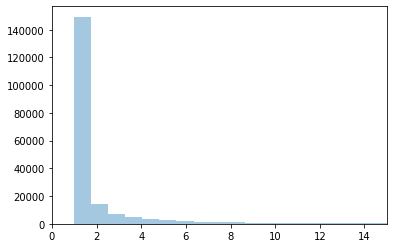

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.distplot(np.square(dist_train),
             bins = 50, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

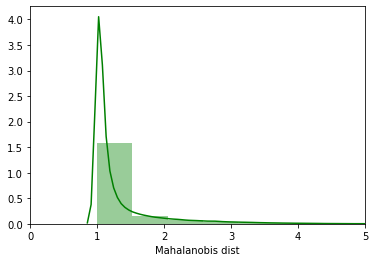

In [18]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [19]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob_dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob_dist'] > anomaly_train['Thresh']
anomaly_train.index = train_PCA.index

In [20]:
anomalies = anomaly_train[anomaly_train['Anomaly'] == True]
print(anomalies)
print(anomalies.shape)

        Mob_dist    Thresh  Anomaly
97012   4.045693  3.904435     True
97036   4.620081  3.904435     True
97045   4.290982  3.904435     True
97053   4.334778  3.904435     True
97230   4.270115  3.904435     True
...          ...       ...      ...
193481  3.915036  3.904435     True
193544  4.914238  3.904435     True
193611  4.647703  3.904435     True
193687  3.977690  3.904435     True
193735  3.945180  3.904435     True

[1355 rows x 3 columns]
(1355, 3)


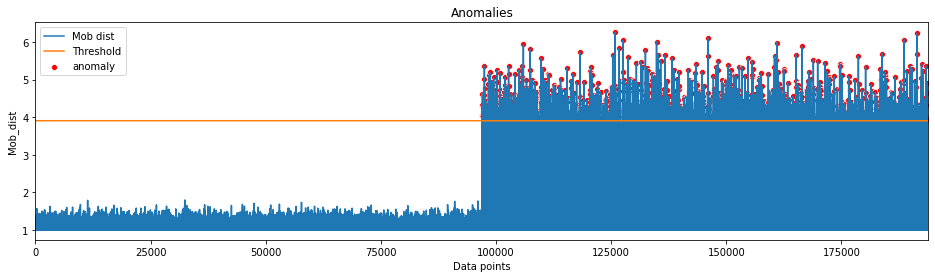

In [21]:
f, (ax1) = plt.subplots(figsize=(16, 4))
ax1.plot(anomaly_train.index, anomaly_train.Mob_dist, label='Mob dist');
ax1.plot(anomaly_train.index, anomaly_train.Thresh, label='Threshold')
g = sns.scatterplot(x=anomalies.index , y=anomalies.Mob_dist, label='anomaly', color='red')
g.set(xlim = (0, len(anomaly_train.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.legend();

In [22]:
anomaly_test = pd.DataFrame()
anomaly_test['Mob_dist']= dist_test
anomaly_test['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_test['Anomaly'] = anomaly_test['Mob_dist'] > anomaly_test['Thresh']
anomaly_test.index = test_PCA.index
anomaly_test.head()

,Mob_dist,Thresh,Anomaly
0,1.010065,3.904435,False
1,1.010566,3.904435,False
2,1.100844,3.904435,False
3,1.007196,3.904435,False
4,1.000107,3.904435,False


In [23]:
OR_anomalies = anomaly_test[anomaly_test['Anomaly'] == True]
print(OR_anomalies)
print(OR_anomalies.shape)

       Mob_dist    Thresh  Anomaly
24296  3.933569  3.904435     True
24310  4.184114  3.904435     True
24430  5.045921  3.904435     True
24721  5.756256  3.904435     True
24935  3.972844  3.904435     True
...         ...       ...      ...
47989  4.334135  3.904435     True
48112  4.304298  3.904435     True
48133  4.437652  3.904435     True
48142  4.191492  3.904435     True
48217  3.994627  3.904435     True

[337 rows x 3 columns]
(337, 3)


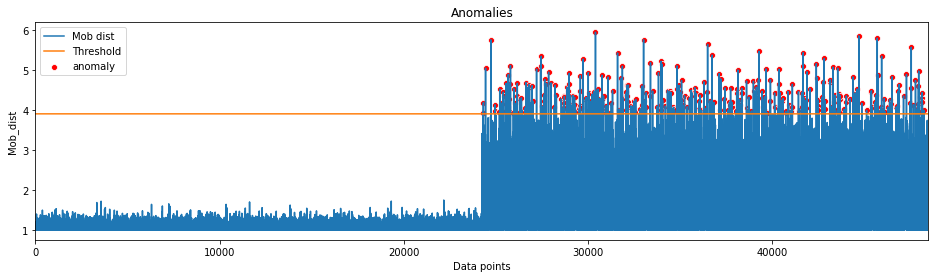

In [24]:
f, (ax2) = plt.subplots(figsize=(16, 4))
ax2.plot(anomaly_test.index, anomaly_test.Mob_dist, label='Mob dist');
ax2.plot(anomaly_test.index, anomaly_test.Thresh, label='Threshold')
g = sns.scatterplot(x=OR_anomalies.index , y=OR_anomalies.Mob_dist, label='anomaly', color='red')
g.set(xlim = (0, len(anomaly_test.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.legend();

In [25]:
print("Anomalies: {}".format(OR_anomalies['Anomaly'].count()))

Anomalies: 337
